# **Projet de Classification d'Images - Livrable 1**

## **1. Introduction du projet**

Ce projet s'inscrit dans le cadre d'une solution de **classification d'images** pour l'entreprise TouNum, spécialisée dans la numérisation de documents. L'objectif principal de ce livrable est de développer un modèle de **réseau de neurones convolutif (CNN)** capable de distinguer automatiquement des photos d'autres types d'images (schémas, peintures, dessins, scans de textes, etc.). Cette classification permettra à l'entreprise d'automatiser le tri des images, améliorant ainsi l'efficacité des processus de traitement et de gestion de grandes quantités de données numérisées.

La problématique de la classification d'images est un sujet central dans le domaine du **deep learning**, notamment dans les contextes où les datasets sont hétérogènes, comme c'est le cas ici. Les images à classifier présentent des caractéristiques visuelles très différentes : les photos et les peintures peuvent partager des similarités complexes, tandis que les schémas ou les textes scannés sont visuellement distincts. L'enjeu est donc de concevoir un modèle suffisamment robuste pour non seulement distinguer ces différentes classes mais aussi généraliser à des nouvelles données.

Pour cela, nous allons nous appuyer sur un **modèle de réseau de neurones convolutif (CNN)**, une architecture qui a fait ses preuves pour les tâches de classification d'images, en raison de sa capacité à capturer efficacement les motifs locaux à différentes échelles. Dans ce livrable, nous nous concentrons sur une classification binaire qui vise à distinguer les photos du reste des images.

Le modèle sera implémenté en **Python** à l'aide du framework **TensorFlow**, largement utilisé pour le développement de modèles de deep learning. Pour garantir une performance optimale, des techniques telles que l'**augmentation des données**, la **régularisation** et l'utilisation de **callbacks** (comme l'early stopping et le checkpointing) seront explorées. Nous examinerons également les performances du modèle via des métriques comme l'**accuracy** et la **perte**, en traçant leur évolution pendant l'entraînement.

En fin de compte, ce projet vise à fournir à TouNum une solution automatisée qui s'intègre dans leur chaîne de production, tout en offrant une base solide pour des développements futurs dans des domaines connexes comme l'**annotation d'images** ou le **captioning automatique**.

## **2. Préparation des données**

### **2.1. Importation des bibliothèques**
Dans cette étape, nous importons un ensemble de bibliothèques Python nécessaires pour l'entraînement du modèle et la manipulation des données :

- `warnings`: Pour filtrer les avertissements non critiques afin de rendre les sorties du notebook plus lisibles.
- `os`: Permet de gérer les opérations liées au système d'exploitation, telles que la création de dossiers et la gestion des chemins.
- `datetime`: Utilisée pour générer des horodatages et organiser les fichiers de logs et de modèles.
- `zipfile`: Pour manipuler les fichiers compressés au format `.zip`, utile pour décompresser les datasets.
- `tqdm`: Permet d'afficher des barres de progression pour suivre les opérations longues.
- `gdown`: Utilisé pour télécharger des fichiers à partir de Google Drive (pratique pour récupérer des datasets).
- `glob`: Permet de trouver des fichiers et des répertoires en fonction de motifs spécifiques.
- `matplotlib.pyplot`: La bibliothèque de visualisation pour tracer les courbes et graphiques nécessaires à l'analyse des résultats.
- `tensorflow`: La bibliothèque principale utilisée pour créer et entraîner les réseaux de neurones.

In [1]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### **2.2. Configuration des chemins et des répertoires**

Afin de bien organiser le projet, plusieurs chemins de fichiers et répertoires sont créés pour stocker les datasets, les modèles et les logs d'entraînement. Cela facilite la gestion des fichiers et permet de garder une structure claire.

In [2]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

is_docker = os.environ.get('IS_DOCKER', False)

if is_docker:
    print("Docker usage detected")
    project_path = f"{project_path}/livrable_1"
else:
    print("Normal usage detected")

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model",
    "plot_test_plan": f"{project_path}/test_plan"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 180
image_w = 180
batch_s = 32

Normal usage detected
Deleting /Users/mohamed/Documents/FISE A5/z/livrable_1/data/validation/unsorted
Deleting /Users/mohamed/Documents/FISE A5/z/livrable_1/data/validation/sorted


### **2.3. Téléchargement et extraction du dataset**

Pour entraîner le modèle de classification, nous avons besoin d'un dataset contenant les images à classer. Le dataset est stocké dans un fichier compressé `.zip` disponible sur Google Drive. La fonction suivante télécharge ce dataset, si nécessaire, et l'extrait dans le répertoire approprié.

In [3]:
def download_dataset(force=False):
    
    dataset_path = f"{paths['train_data_path']}/dataset.zip"

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1vhNmk5omNcX3g9enqETvFR_2vdVONsxo'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(paths['train_data_path'])) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, paths['train_data_path'])
                        pbar.update(1)
            zip_ref.extractall(paths['train_data_path'])
            print(f"Dataset downloaded {paths['train_data_path']}")
        
download_dataset()

Dataset already downloded
Dataset already exported


### **2.4. Vérification de l'intégrité des images**

Il est important de s'assurer que toutes les images du dataset sont valides avant de les utiliser pour l'entraînement du modèle. Des fichiers corrompus ou non valides pourraient causer des erreurs lors du chargement ou de l'entraînement du modèle. La fonction suivante permet de parcourir toutes les images du dataset et de vérifier si elles peuvent être correctement lues par TensorFlow.

In [4]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)
            
        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

### **2.5. Création du jeu de validation**

Il est essentiel de disposer d'un jeu de validation distinct pour évaluer les performances du modèle sur des données qu'il n'a pas encore vues. La fonction suivante permet de copier un certain nombre d'images (par défaut 20) depuis chaque sous-dossier d'entraînement vers un dossier de validation.

Cette étape est cruciale pour s'assurer que le modèle est capable de bien généraliser, c'est-à-dire d'effectuer des prédictions précises sur des images nouvelles, et non simplement de mémoriser les images d'entraînement.

In [5]:
def create_validation_set(num_files_to_copy=20):
    for folder in os.listdir(paths['train_data_path']):
        if folder.endswith(".zip"):
            continue
        folder_path = os.path.join(paths['train_data_path'], folder)
        files = os.listdir(folder_path)
        files_to_copy = random.sample(files, num_files_to_copy)
        for file in files_to_copy:
            src_file = os.path.join(folder_path, file)
            dest_file = os.path.join(paths['unsorted_validation_data_path'], file)
            shutil.copy2(src_file, dest_file)

create_validation_set()

### **2.6. Chargement des données d'entraînement et de test**

Pour entraîner et évaluer le modèle, nous avons besoin de charger les images depuis les répertoires dans lesquels elles sont stockées. TensorFlow propose une méthode pratique avec `image_dataset_from_directory` qui permet de charger directement les images depuis un répertoire et de les transformer en un format compatible avec les réseaux de neurones.

In [6]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 32755 files belonging to 5 classes.
Using 26204 files for training.
Using 6551 files for validation.


### **2.7. Extraction des noms des classes**

Après avoir chargé les datasets d'entraînement et de validation, nous pouvons extraire les noms des classes à partir du dataset. TensorFlow fournit automatiquement les noms de classes en fonction des sous-dossiers du répertoire de données. Cela nous permet de mieux comprendre la répartition des catégories dans les données.

In [7]:
class_names = test_set.class_names
class_num = len(class_names)
print(class_names)

['painting', 'photo', 'schematics', 'sketch', 'text']


### **2.8. Prétraitement des images**

Avant d'envoyer les images au modèle de réseau de neurones pour l'entraînement, il est important de les préparer de manière cohérente. Cette étape consiste à redimensionner toutes les images à une taille commune tout en conservant leur ratio d'aspect. Cela garantit que les images ont des dimensions uniformes (180*180 pixels) sans distorsion, grâce à l'ajout de padding si nécessaire.

In [8]:
def preprocess_image(image, label):
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

### **2.9. Visualisation des images**

Avant d'entraîner le modèle, il est utile de visualiser quelques exemples d'images du dataset pour vérifier que le chargement et le prétraitement des données ont été correctement effectués. La fonction `print_img()` affiche un échantillon d'images avec leurs étiquettes respectives.

Image shape:  (32, 180, 180, 3)
Labels shape:  (32,)


2024-10-09 19:56:50.808703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


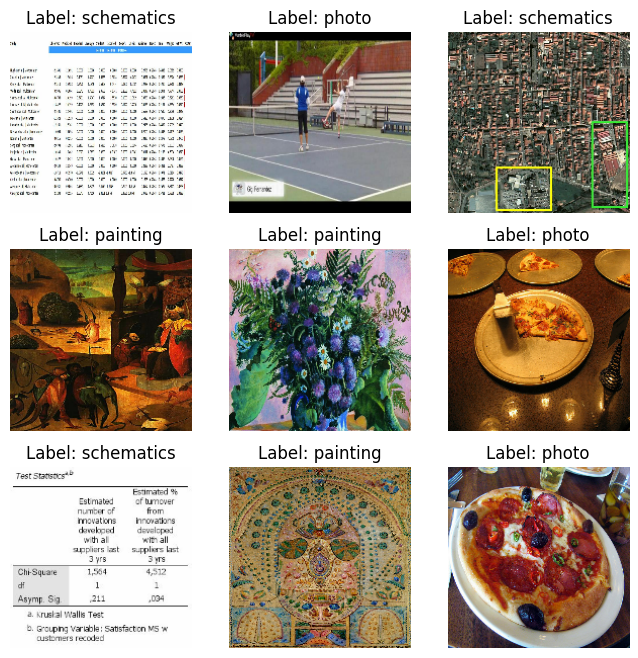

In [9]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()
        
images, labels = iter(train_set).next()
print("Image shape: ", images.shape)
print("Labels shape: ", labels.shape)
print_img(train_set, 9)

### **2.10. Optimisation des Performances des Données**

Pour garantir un entraînement efficace et éviter les goulots d'étranglement en termes de performances, il est essentiel d'optimiser non seulement le modèle, mais aussi le traitement des données. Cette section se concentre sur l’utilisation de techniques spécifiques dans TensorFlow pour maximiser l’efficacité du flux de données pendant l’entraînement, notamment en gérant le cache, le préchargement et le mélange des données. Ces optimisations permettent de réduire les temps d’attente pendant l’entraînement tout en garantissant une meilleure généralisation du modèle.

#### **2.10.1 AUTOTUNE**

L’argument `AUTOTUNE` de TensorFlow permet d’ajuster dynamiquement la taille du buffer de préchargement des données. Le but est de déterminer automatiquement les paramètres optimaux pour le pipeline de données, en fonction des ressources disponibles sur la machine, comme la mémoire et les cœurs du processeur.


#### **2.10.2. Mise en Cache des Données**

L’instruction `.cache()` stocke les données prétraitées en mémoire après leur premier passage. Cela permet d’éviter de relire et de recharger les images du disque à chaque époque d’entraînement, une opération coûteuse en temps.

#### **2.10.3. Mélange Aléatoire des Données**

Le mélange des données avant chaque époque est un processus essentiel pour garantir que le modèle ne voit jamais les données dans un ordre fixe, ce qui améliorerait artificiellement ses performances et pourrait entraîner un surapprentissage.

- **Pourquoi mélanger les données ?**
  
  Si les données sont toujours présentées au modèle dans le même ordre, il pourrait mémoriser des séquences spécifiques ou se concentrer de manière inégale sur certaines parties du dataset, ce qui compromettrait sa capacité à généraliser sur des données non vues. Le mélange aléatoire des données (`shuffle()`) permet d'assurer que chaque époque présente les données dans un ordre différent, réduisant ainsi la corrélation entre les échantillons successifs.

- **Paramètre de taille du buffer (`1000`) :**
  
  Le nombre `1000` indique la taille du buffer utilisé pour mélanger les données. Ce buffer contient un sous-ensemble des données qui est mélangé avant d'être passé au modèle. Le choix de la taille du buffer est important : un buffer trop petit pourrait ne pas mélanger efficacement les données, tandis qu’un buffer trop grand pourrait être coûteux en mémoire. Le choix de `1000` est un compromis entre ces deux extrêmes, garantissant un mélange efficace sans surcharge mémoire.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Modèle**

Pour identifier l'architecture de modèle la plus performante, nous avons élaboré un plan d'expérience qui repose sur des ajustements progressifs du modèle initial. Cela inclut des modifications ciblées de l'architecture et des réglages minutieux des hyperparamètres clés.

Chaque variante du modèle a été évaluée à l'aide de métriques de validation, puis comparée afin de déterminer laquelle généralise le mieux sur des données inédites. Ce processus itératif nous permet d'optimiser le modèle en trouvant un équilibre entre précision et complexité, garantissant ainsi des performances optimales.

### **3.1. Création du modèle**

Les réseaux de neurones convolutifs (CNN) sont largement reconnus comme l’architecture de référence pour les tâches de classification d'images en **deep learning**. Leur conception, qui exploite les relations spatiales entre les pixels, est parfaitement adaptée au traitement des données visuelles. Dans ce projet, la fonction `create_model` implémente un modèle CNN, optimisé pour classifier efficacement les images numérisées fournies.

#### Pourquoi utiliser un CNN pour ce projet ?

1. **Extraction automatique des caractéristiques**
   Les CNN se distinguent par leur capacité à apprendre des représentations hiérarchiques directement à partir des données d'entrée, sans nécessiter de prétraitement manuel des caractéristiques. À travers les couches convolutionnelles, le modèle extrait automatiquement des motifs de plus en plus complexes : les premières couches capturent des motifs simples comme les bords ou les textures, tandis que les couches plus profondes apprennent des caractéristiques globales telles que la forme ou l'objet lui-même. Cette approche est particulièrement avantageuse pour notre projet, où les images peuvent être très variées en termes de contenu (photos, schémas, peintures, etc.).

2. **Invariance aux translations et aux déformations**
   L’un des grands avantages des CNN réside dans leur invariance spatiale. Grâce à l'utilisation de couches de **pooling** et de filtres partagés, les CNN sont capables de détecter des motifs visuels même lorsqu’ils subissent des transformations géométriques comme des rotations, des redimensionnements ou des translations. Pour ce projet, où les images numérisées peuvent être variées en termes d'orientation ou de perspective, cette capacité à identifier des motifs de manière robuste est essentielle.

3. **Efficacité computationnelle**
   Les CNN exploitent le partage de poids, ce qui permet d'optimiser le nombre de paramètres à entraîner. Contrairement aux réseaux entièrement connectés (fully connected), où chaque neurone est connecté à tous les autres, les CNN utilisent des filtres qui se déplacent localement sur l'image, réduisant ainsi la complexité. Cela permet d'entraîner des modèles plus profonds et plus puissants sans nécessiter une quantité excessive de mémoire ou de temps de calcul. Cette efficacité est critique dans un contexte de traitement à grande échelle, comme celui de ce projet.

4. **Succès éprouvé dans la classification d'images**
   Les CNN ont prouvé leur efficacité dans de nombreux benchmarks de classification d'images, y compris des jeux de données très complexes comme **ImageNet**. Les architectures CNN sont à la base des meilleures performances dans des compétitions internationales, confirmant leur capacité à généraliser sur des données visuelles variées. L’utilisation d’un CNN pour ce projet est donc justifiée pour garantir une haute précision et une robustesse dans la classification des images.

#### Détails du Modèle CNN Implémenté

La fonction `create_model` est structurée de la manière suivante :

- **Couches Convolutionnelles (Conv2D)** : Chaque couche convolutionnelle applique plusieurs filtres qui balayent l’image pour détecter des motifs spécifiques. Les premières couches capturent des caractéristiques simples comme les bords et les textures, tandis que les couches plus profondes extraient des informations plus complexes.
  
- **Couches de Pooling (MaxPooling2D)** : Ces couches réduisent la dimension des cartes de caractéristiques tout en conservant les informations les plus importantes. Cela permet de diminuer le nombre de paramètres, rendant le modèle plus efficace sans perte significative de performance. De plus, le pooling introduit une invariance aux petites translations des objets dans les images.

- **Couches Fully Connected (Dense)** : Ces couches, situées en fin de réseau, transforment les caractéristiques extraites par les couches convolutionnelles en un vecteur de classification. Ces couches apprennent à combiner les informations locales pour effectuer une classification globale de l'image.

- **Fonctions d'activation** :
  - **ReLU** (Rectified Linear Unit) est utilisée après chaque couche convolutionnelle. Cette fonction d'activation introduit de la non-linéarité, ce qui permet au modèle de capturer des relations complexes dans les données.
  
  - **Softmax** est utilisée en sortie pour convertir les prédictions en probabilités, permettant ainsi de classifier les images en fonction de leur classe.

#### Choix de la Fonction de Perte : **Cross-Entropy Categorical**

La **fonction de perte** utilisée pour ce modèle est la **cross-entropie catégorielle**. Elle est particulièrement adaptée aux tâches de classification multi-classes comme celle-ci, car elle mesure la distance entre la distribution des probabilités prédites par le modèle et les étiquettes réelles. En minimisant cette fonction de perte, le modèle est entraîné à améliorer la précision de ses prédictions, ajustant ses poids à chaque itération pour réduire l’erreur sur les données d'entraînement.

#### Choix de l’Optimiseur : **Adam**

L’optimiseur **Adam** a été sélectionné pour ce projet en raison de ses nombreux avantages par rapport aux algorithmes d'optimisation plus classiques comme **SGD (Stochastic Gradient Descent)**. Adam combine la descente de gradient avec moment et l'adaptation des taux d'apprentissage pour chaque paramètre, ce qui en fait un optimiseur efficace, en particulier dans des environnements où les gradients peuvent être bruités ou non stationnaires, comme c’est souvent le cas dans les tâches de classification d'images.

- **Adaptation du taux d'apprentissage** : Contrairement à SGD qui utilise un taux d'apprentissage constant, Adam ajuste dynamiquement le taux d'apprentissage pour chaque paramètre, permettant ainsi une convergence plus rapide et plus stable.

- **Résistance aux gradients bruyants** : Adam utilise deux moments (le moment de premier ordre pour la moyenne des gradients et le moment de second ordre pour la variance des gradients), ce qui permet d'atténuer l’effet des gradients bruyants ou mal estimés. Cela est particulièrement utile lorsque les données d'entraînement sont hétérogènes, comme dans le dataset de ce projet.
  

In [11]:
def create_test_model(
    batch_size,
    loss_function,
    optimizer,
    dropout_rate,
    regularization_value=None,
    filter_factor=1,
    use_data_augmentation=False,
    add_additional_layer=False,
    use_batch_normalization=False,
    image_height=180,
    image_width=180
):    
    # Define L2 regularizer if needed
    regularizer = tf.keras.regularizers.l2(regularization_value) if regularization_value else None

    # Initialize the model
    model = tf.keras.models.Sequential()

    # Normalize input pixels
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)))

    # Add data augmentation layer if specified
    if use_data_augmentation:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        model.add(data_augmentation)

    # First convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=16 * filter_factor,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizer
    ))
    
    if use_batch_normalization:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=32 * filter_factor,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizer
    ))

    if use_batch_normalization:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Add an additional convolutional layer if specified
    if add_additional_layer:
        model.add(tf.keras.layers.Conv2D(
            filters=64 * filter_factor,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizer
        ))

        if use_batch_normalization:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Flatten outputs for the dense layer
    model.add(tf.keras.layers.Flatten())
    
    # Final dense layer
    model.add(tf.keras.layers.Dense(128 * filter_factor, activation="relu"))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(class_num, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Display a model summary
    model.summary()
    
    return model

### **3.2. Définition des Callbacks**

Les **callbacks** dans TensorFlow/Keras permettent d'intégrer des actions spécifiques pendant le processus d'entraînement du modèle. Dans ce projet, nous utilisons trois types de callbacks qui jouent un rôle crucial dans l'optimisation de l'entraînement et la surveillance des performances :

#### 3.2.1. **ModelCheckpoint**

Le **ModelCheckpoint** est utilisé pour sauvegarder périodiquement les poids du modèle. Plus précisément, il enregistre les poids du modèle après chaque epoch où une amélioration est observée sur les données de validation, en fonction d’une métrique donnée (par exemple, la perte ou l’accuracy sur l'ensemble de validation). Ce mécanisme est particulièrement important pour plusieurs raisons :

- **Conserver les meilleures performances** : Seules les meilleures versions du modèle sont sauvegardées, évitant la dégradation due au surentraînement.

- **Prévenir les pertes de progrès** en cas d'interruption.

- **Limiter le surapprentissage** en enregistrant uniquement les poids correspondant aux meilleures performances.

#### 3.2.2. **TensorBoard**

Le **callback TensorBoard** permet de générer des journaux d'entraînement qui peuvent être visualisés avec l'outil **TensorBoard**. TensorBoard est un outil essentiel pour le diagnostic et la surveillance en temps réel de l’entraînement, car il offre plusieurs avantages techniques :

- **Visualiser l’évolution des performances** (perte, précision) sur les données d’entraînement et de validation.

- **Suivre les gradients et poids du modèle** pour détecter des anomalies comme le vanishing gradient.

- **Analyser les temps d’entraînement** pour optimiser les performances.

#### 3.2.3. **EarlyStopping**

Le callback **EarlyStopping** est utilisé pour arrêter automatiquement l'entraînement lorsque les performances sur le jeu de validation cessent de s'améliorer après un certain nombre d'epoch consécutives (défini par le paramètre `patience`). Cette technique repose sur l'idée qu'après un certain point, continuer l'entraînement n'améliore plus les performances générales du modèle et risque même de le dégrader (surapprentissage). Les raisons principales d'utiliser EarlyStopping sont les suivantes :

- **Éviter le surentraînement** et améliorer la généralisation.

- **Réduire le temps d'entraînement** en stoppant avant saturation.

- **Simplifier l’ajustement manuel** des époques d’entraînement.


In [12]:
def get_callbacks():    
    # Create a callback that saves the model's weights at each epoch where validation loss improves
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    
    # Create a TensorBoard callback to log training metrics, model graphs, and images for visualization
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )
    
    # Set up early stopping to halt training if validation loss stops improving for a set number of epochs
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]

Nous traçons des graphiques pour visualiser les performances du modèle pendant l'entraînement. Cela inclut l'évolution de l'accuracy et de la perte, à la fois sur les données d'entraînement et de validation, au fil des epoch. Ces graphiques nous aident à comprendre comment le modèle s'améliore et à identifier d'éventuels problèmes comme le surapprentissage.

In [13]:
def plot_training_history(history, file_name):

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    # Save the plot to the specified path
    plt.savefig(f"{paths['plot_test_plan']}/{file_name}")

    # Display the plot
    plt.show()


### **3.3. Évolution du Modèle : Une Optimisation Itérative et Approfondie**

#### 3.3.1. **Modèle Initial : Une Architecture de Base pour Réseaux Convolutifs**

Le modèle initial était conçu comme un réseau de neurones convolutifs (CNN) standard, structuré pour effectuer la classification d’images. Il comprenait les composants suivants :

- **Deux couches convolutionnelles**, chacune suivie d’une couche de **MaxPooling**. Les filtres étaient de taille croissante (16 et 32), permettant d'extraire des caractéristiques de plus en plus complexes à chaque couche.
- **Dropout modéré fixé à 0.2** après chaque couche de pooling, utilisé comme une méthode de régularisation élémentaire pour éviter le sur-apprentissage.
- **Pas de régularisation explicite (L2 ou L1)** au niveau des poids, ce qui laissait le modèle libre d'apprendre sans contrainte, mais le rendait vulnérable au sur-apprentissage avec l’augmentation de la complexité.

Le schéma ci-dessous illustre cette architecture :

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,294,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,300,261 (31.66 MB)

 Trainable params: 8,300,261 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2024-10-09 19:57:01.894783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 467 of 1000
2024-10-09 19:57:05.787133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  1/819 ━━━━━━━━━━━━━━━━━━━━ 4:14:05 19s/step - accuracy: 0.3125 - loss: 1.5110

2024-10-09 19:57:09.820020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5936 - loss: 1.1740
Epoch 1: val_loss improved from inf to 0.53255, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.53.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 105s 106ms/step - accuracy: 0.5938 - loss: 1.1735 - val_accuracy: 0.7900 - val_loss: 0.5326
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8218 - loss: 0.4437
Epoch 2: val_loss improved from 0.53255 to 0.43485, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.43.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.8218 - loss: 0.4437 - val_accuracy: 0.8303 - val_loss: 0.4349
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8647 - loss: 0.3444
Epoch 3: val_loss improved from 0.43485 to 0.41095, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-03-0.41.weights.h5
819/819 ━━━━━

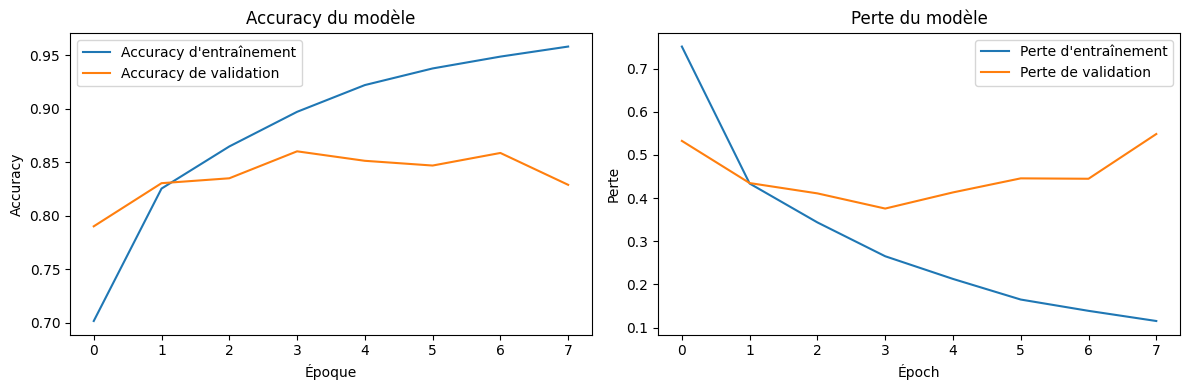

In [14]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Create the model and get the datasets
first_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',  # Choosing an optimizer, here Adam
    dropout_rate=0.2,  # Dropout rate for slight regularization
    regularization_value=None,  # No regularization
    filter_factor=1,  # Default filter factor
    use_data_augmentation=False,  # No data augmentation for this first trial
    add_additional_layer=False,  # Only two layers
    use_batch_normalization=False,  # No Batch Normalization for the first model
    image_height=image_h,
    image_width=image_w
)

# Train the model
epochs = 10

history_first_model = first_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks()
)

# Visualize the model's performance
plot_training_history(history_first_model, "1_initial_model.png")

#### 3.3.2. **Modèle à 3 couches : Vers une architecture plus complexe**

Le second modèle introduit une complexité supplémentaire par rapport au modèle initial, avec les ajustements suivants :

- **Trois couches convolutionnelles**, chacune suivie d’une couche de **MaxPooling**. Les filtres ont des tailles croissantes (16, 32, puis 64), ce qui permet d'extraire des caractéristiques de plus en plus complexes au fil des couches.
- **Un Dropout modéré fixé à 0.2** après chaque couche de pooling, utilisé comme une technique de régularisation pour limiter le surapprentissage.
- **Toujours aucune régularisation explicite (L2 ou L1)** au niveau des poids, mais l'augmentation de la profondeur du réseau apporte davantage de capacités d'apprentissage, tout en augmentant les risques de surapprentissage si le modèle n'est pas bien contrôlé.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6035 - loss: 0.9395
Epoch 1: val_loss improved from inf to 0.45615, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.46.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - accuracy: 0.6036 - loss: 0.9392 - val_accuracy: 0.8138 - val_loss: 0.4561
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8149 - loss: 0.4633
Epoch 2: val_loss improved from 0.45615 to 0.40174, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.40.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 112ms/step - accuracy: 0.8149 - loss: 0.4633 - val_accuracy: 0.8358 - val_loss: 0.4017
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8473 - loss: 0.3829
Epoch 3: val_loss did not improve from 0.40174
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 112ms/step - accuracy: 0.8473 - loss: 0.3829 - val_accuracy: 0.8304 - val_loss: 0.4306

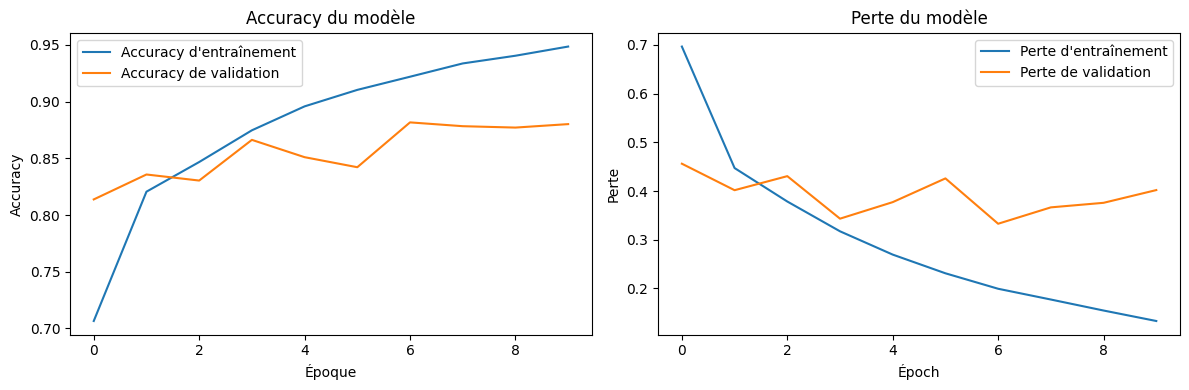

In [16]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Create the second model with an additional third layer
second_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.2,
    regularization_value=None,
    filter_factor=1,
    use_data_augmentation=False,
    add_additional_layer=True,
    use_batch_normalization=False,
    image_height=image_h,
    image_width=image_w
)

# Train the second model
epochs = 10

history_second_model = second_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks()
)

# Visualize the performance of the second model
plot_training_history(history_second_model, "2_extra_layer_model.png")

#### 3.3.3. **Augmentation des Données**

L’augmentation des données (**data augmentation**) est une technique essentielle pour améliorer la robustesse et la capacité de généralisation du modèle, en particulier lorsque le dataset est de taille limitée ou que certaines classes sont sous-représentées. Cette méthode repose sur l'application de transformations aléatoires aux images d'entraînement, créant ainsi des variantes artificielles tout en conservant les propriétés essentielles des données. Cela permet au modèle d’apprendre à identifier les caractéristiques des images dans des conditions variées et réalistes.

#### Pourquoi l'augmentation des données est-elle nécessaire ?

1. **Amélioration de la généralisation**
   
   Un des principaux défis en deep learning est d'assurer que le modèle ne se contente pas de mémoriser les données d'entraînement, mais qu'il puisse aussi généraliser à des données qu’il n’a jamais vues. L'augmentation des données simule cette variabilité en créant des versions modifiées des images existantes, ce qui augmente virtuellement la taille du dataset et diversifie les exemples que le modèle voit durant l’entraînement.

2. **Prévention du surapprentissage (overfitting)**
   
   Lorsque le dataset est limité, il est facile pour un modèle puissant comme un CNN de surapprendre les détails spécifiques des images d'entraînement, conduisant à une mauvaise performance sur les données de validation ou en production. En introduisant des transformations aléatoires, l’augmentation des données rend le modèle moins susceptible de mémoriser les exemples spécifiques et l'oblige à apprendre des représentations plus robustes et généralisables.

3. **Enrichissement du dataset**
   
   L'augmentation des données permet d'introduire une diversité dans les images, en simulant des conditions que le modèle pourrait rencontrer dans des situations réelles, comme des variations de lumière, des rotations, des zooms, etc. Cela est particulièrement utile dans le cas d'un dataset hétérogène ou lorsque certaines classes d'images sont peu représentées.

#### Techniques Utilisées pour l'Augmentation des Données

Dans ce projet, plusieurs techniques d'augmentation des données sont mises en œuvre, chacune ayant pour objectif de simuler des transformations réalistes des images tout en préservant leur signification sémantique :

1. **RandomFlip (Renversement horizontal)**
   
   Le renversement horizontal est l'une des méthodes d'augmentation les plus simples et les plus efficaces. Il permet de doubler virtuellement la taille du dataset en générant des versions symétriques des images. Cette technique est particulièrement utile dans les tâches où l'orientation gauche/droite d'un objet ou d'une scène ne change pas la classe à laquelle il appartient (par exemple, des paysages ou des bâtiments). En introduisant des images renversées, le modèle apprend à être moins sensible à la symétrie des objets, améliorant ainsi sa capacité de généralisation.

2. **RandomRotation (Rotation aléatoire)**
   
   La rotation aléatoire des images, dans une plage de ±10%, permet de rendre le modèle invariant à l'orientation des objets. Ceci est crucial dans un contexte de classification d'images, où l'angle de prise de vue peut varier. La rotation permet au modèle de reconnaître les objets sous des angles différents, ce qui est essentiel dans des scénarios où les images peuvent ne pas être parfaitement alignées (comme dans le cas de documents numérisés de manière non uniforme).

3. **RandomZoom (Zoom aléatoire)**
   
   Le zoom aléatoire de ±10% permet de simuler des variations dans la distance entre l'objet et la caméra. Cela aide le modèle à apprendre à reconnaître les objets ou les motifs à différentes échelles, en renforçant sa robustesse face à des images où l'objet occupe plus ou moins d’espace dans le cadre. Cette transformation est particulièrement utile pour éviter que le modèle ne devienne trop dépendant d'une certaine échelle lors de l'apprentissage.

#### Avantages de l'augmentation des données utilisée

Les trois techniques d'augmentation utilisées dans ce projet visent à enrichir le dataset en simulant des variations courantes dans des contextes réels, tout en maintenant la pertinence sémantique des images. L'augmentation des données est essentielle pour :

- **Réduire le surapprentissage** : En créant des images modifiées à partir des exemples d'entraînement, le modèle apprend à reconnaître les objets dans diverses conditions, ce qui réduit la dépendance à des exemples spécifiques et améliore sa capacité de généralisation.
  
- **Améliorer la robustesse aux transformations** : Les transformations appliquées (flip, rotation, zoom) simulent des conditions réalistes que le modèle pourrait rencontrer en production, rendant le modèle plus robuste aux variations d'orientation et d'échelle dans les images.

- **Augmenter virtuellement la taille du dataset** : Avec seulement trois transformations, le dataset est virtuellement agrandi, ce qui permet au modèle de s’entraîner sur un ensemble de données plus diversifié sans avoir besoin de collecter des images supplémentaires.

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5336 - loss: 1.2752
Epoch 1: val_loss improved from inf to 0.90775, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.91.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 123ms/step - accuracy: 0.5336 - loss: 1.2748 - val_accuracy: 0.6373 - val_loss: 0.9078
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7081 - loss: 0.6886
Epoch 2: val_loss improved from 0.90775 to 0.75361, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.75.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 124ms/step - accuracy: 0.7081 - loss: 0.6886 - val_accuracy: 0.6808 - val_loss: 0.7536
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7635 - loss: 0.5789
Epoch 3: val_loss improved from 0.75361 to 0.51163, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-03-0.51.weights.

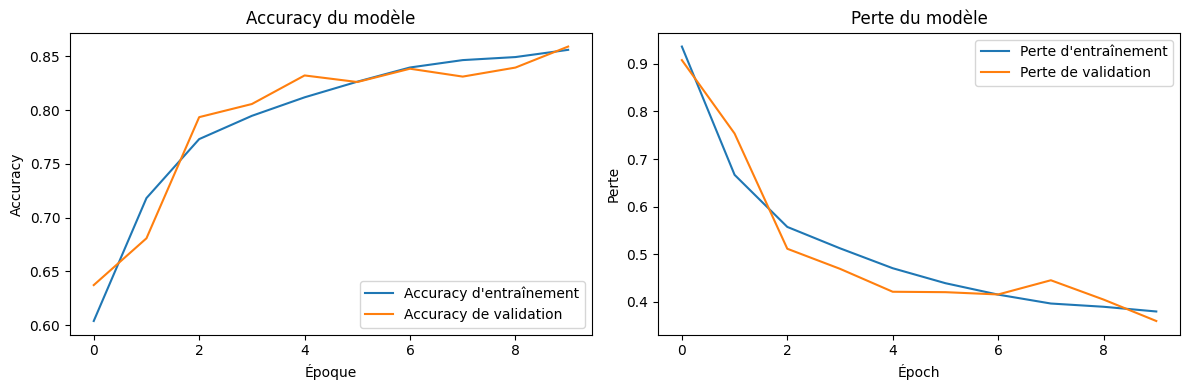

In [18]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Create the third model with an additional third layer and data augmentation
third_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.2,
    regularization_value=None,
    filter_factor=1,
    use_data_augmentation=True,
    add_additional_layer=True,
    use_batch_normalization=False,
    image_height=image_h,
    image_width=image_w
)

# Train the third model
epochs = 10

history_third_model = third_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks()
)

# Visualize the performance of the third model
plot_training_history(history_third_model, "3_data_augmentation_model.png")

#### 3.3.4. ****Introduction de Batch Normalization : Un Impact Mitigé****

L'une des premières optimisations apportées fut l'ajout de ****Batch Normalization**** après chaque couche convolutionnelle. Cette technique est généralement utilisée pour stabiliser et accélérer l'apprentissage, notamment en :

- ****Normalisant les activations*** au sein des couches, ce qui permet de réduire la sensibilité aux variations de distribution des données internes.
- ****Permettant des taux d’apprentissage plus élevés*** tout en améliorant la convergence.

Cependant, dans ce cas précis, les performances de validation ont montré des ****fluctuations plus importantes**** après l'ajout de Batch Normalization, avec une accuracy qui devenait instable à partir de certaines epoch. Les fluctuations observées indiquaient que, bien que la normalisation ait amélioré l'apprentissage sur le set d'entraînement, elle a également rendu l'apprentissage plus instable sur le set de validation. Ces oscillations ont suggéré que la normalisation seule ne suffisait pas à stabiliser l'ensemble du processus d'entraînement.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,733 (15.22 MB)

 Trainable params: 3,989,509 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5233 - loss: 3.5422
Epoch 1: val_loss improved from inf to 0.80745, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.81.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 145s 176ms/step - accuracy: 0.5234 - loss: 3.5397 - val_accuracy: 0.6541 - val_loss: 0.8075
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6116 - loss: 0.8269
Epoch 2: val_loss improved from 0.80745 to 0.73963, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.74.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.6116 - loss: 0.8269 - val_accuracy: 0.6776 - val_loss: 0.7396
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6381 - loss: 0.7694
Epoch 3: val_loss improved from 0.73963 to 0.68293, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-03-0.68.weights.

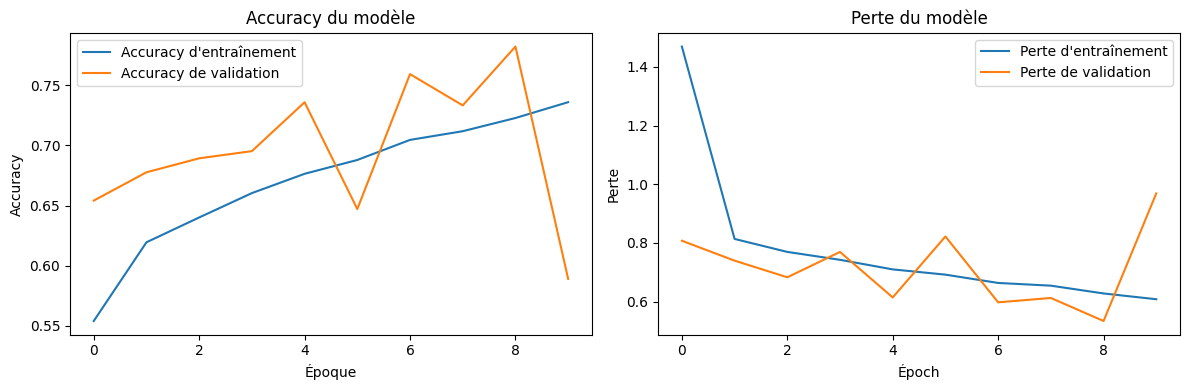

In [19]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Create the fourth model with an additional third layer, data augmentation, and Batch Normalization
fourth_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.2,
    regularization_value=None,
    filter_factor=1,
    use_data_augmentation=True,
    add_additional_layer=True, 
    use_batch_normalization=True,
    image_height=image_h,
    image_width=image_w
)

# Train the fourth model
epochs = 10

history_fourth_model = fourth_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks()
)

# Visualize the performance of the fourth model
plot_training_history(history_fourth_model, "4_batch_normalization_model.png")

#### 3.3.5. ****Ajout de la Régularisation L2 : Un Effet Temporaire****

Pour mieux contrôler la complexité du modèle, une ****régularisation L2**** (λ = 0.001) a été ajoutée aux couches convolutionnelles. La régularisation L2 est souvent utilisée pour pénaliser les poids excessifs et favoriser une généralisation plus stable. Cependant, dans notre cas, bien que cette régularisation ait permis une légère amélioration de l'accuracy de validation dans les premières epoch, elle n'a pas permis de stabiliser complètement le modèle :

- ****Fluctuations persistantes*** : Après plusieurs epoch, les performances sur le set de validation ont continué à osciller, avec des chutes et des hausses inattendues. Cela indiquait que la régularisation L2 ne corrigeait pas entièrement les problèmes de stabilité observés, et en augmentant la régularisation (λ = 0.002), le modèle a même vu ses performances freiner.

Les tests ont montré que la ****régularisation L2****, bien qu'efficace dans certains contextes, n'était pas nécessairement adaptée pour ce modèle et ce dataset spécifique. Cela a conduit à la décision de retirer progressivement cette régularisation dans les versions ultérieures du modèle.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,733 (15.22 MB)

 Trainable params: 3,989,509 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4993 - loss: 2.7111
Epoch 1: val_loss improved from inf to 1.38019, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-1.38.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 172ms/step - accuracy: 0.4994 - loss: 2.7096 - val_accuracy: 0.5198 - val_loss: 1.3802
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5691 - loss: 0.9991
Epoch 2: val_loss improved from 1.38019 to 1.25695, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-1.26.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - accuracy: 0.5691 - loss: 0.9991 - val_accuracy: 0.5378 - val_loss: 1.2570
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5878 - loss: 0.9352
Epoch 3: val_loss improved from 1.25695 to 0.79157, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-03-0.79.weights.

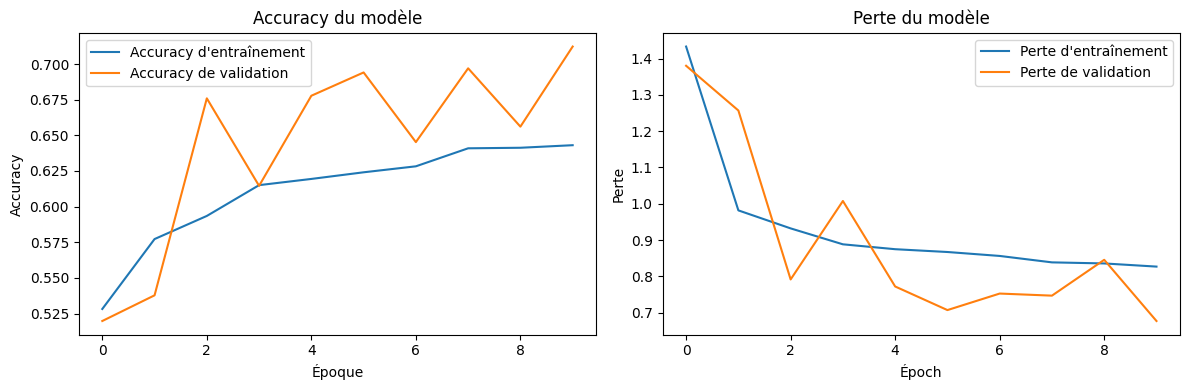

In [20]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Define the L2 regularization value
regularization_value = 0.001 

# Create the fifth model with L2 regularization
fifth_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.2,
    regularization_value=regularization_value, 
    filter_factor=1,
    use_data_augmentation=True, 
    add_additional_layer=True, 
    use_batch_normalization=True, 
    image_height=image_h,
    image_width=image_w
)

# Train the fifth model
epochs = 10

history_fifth_model = fifth_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks()
)

# Visualize the performance of the fifth model
plot_training_history(history_fifth_model, "5_regularization_model.png")

#### 3.3.6. ****Introduction de ReduceLROnPlateau : Une Amélioration de la Convergence****

Pour résoudre les problèmes de fluctuation récurrents, nous avons introduit le callback ****ReduceLROnPlateau****. Ce mécanisme permet de réduire dynamiquement le taux d'apprentissage lorsque les performances de validation stagnent ou se détériorent, afin de permettre une convergence plus stable. Ce callback a permis :

- ***De réduire les oscillations*** : En ajustant automatiquement le taux d’apprentissage, le modèle a pu ajuster plus finement ses poids, ce qui a contribué à diminuer les fluctuations observées précédemment.
- ***Amélioration de la convergence à long terme*** : Le modèle a montré une meilleure stabilité dans les dernières epoch d’entraînement, notamment grâce à des ajustements plus progressifs des poids.

L’introduction de ce callback a permis de renforcer la robustesse du modèle et de mieux gérer les moments où l’apprentissage devenait instable.

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,733 (15.22 MB)

 Trainable params: 3,989,509 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5300 - loss: 2.8453
Epoch 1: val_loss improved from inf to 0.88785, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.89.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 174ms/step - accuracy: 0.5301 - loss: 2.8435 - val_accuracy: 0.6233 - val_loss: 0.8878 - learning_rate: 0.0010
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6338 - loss: 0.8517
Epoch 2: val_loss improved from 0.88785 to 0.74873, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.75.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.6339 - loss: 0.8517 - val_accuracy: 0.6984 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6569 - loss: 0.7959
Epoch 3: val_loss improved from 0.74873 to 0.67055, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/we

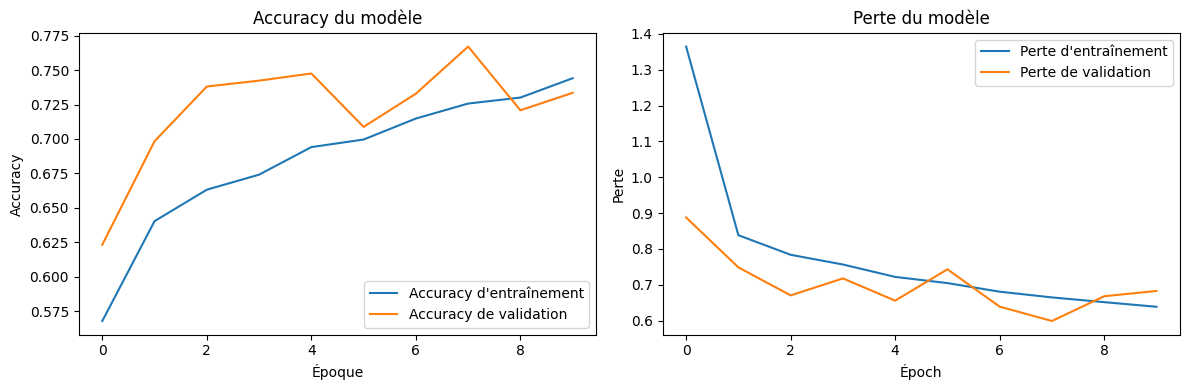

In [21]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Define the L2 regularization value
regularization_value = 0.001

# Create the sixth model with L2 regularization, data augmentation, and Batch Normalization
sixth_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.2,
    regularization_value=regularization_value,
    filter_factor=1,
    use_data_augmentation=True,
    add_additional_layer=True,
    use_batch_normalization=True,
    image_height=image_h,
    image_width=image_w
)

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.5,              # Reduce learning rate by half
    patience=2,              # Wait for 2 epochs before reducing the rate
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Display a message when learning rate is reduced
)

# Train the sixth model with the existing callbacks and ReduceLROnPlateau
epochs = 10

history_sixth_model = sixth_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks() + [reduce_lr]  # Add ReduceLROnPlateau to callbacks
)

# Visualize the performance of the sixth model
plot_training_history(history_sixth_model, "6_reduce_lr_model.png")

#### 3.3.7. **Augmentation de la Complexité et Ajustement des Paramètres**

Après avoir stabilisé le processus d'apprentissage grâce à ReduceLROnPlateau, nous avons exploré une augmentation progressive de la complexité du modèle :

- **Doublement du nombre de filtres** à chaque couche convolutionnelle : Nous sommes passés de 16, 32, 64 filtres à 32, 64, 128, ce qui a permis d'extraire des caractéristiques plus riches et complexes à chaque étape du réseau.
- **Ajustement du Dropout à 0.4** : Nous avons testé un Dropout plus élevé pour renforcer la régularisation. Cependant, un Dropout trop important a limité la capacité d'apprentissage, entraînant une dégradation des performances.

Ces ajustements ont permis une amélioration à court terme de l'apprentissage, mais il est apparu qu'une régularisation excessive (Dropout ou L2) ralentissait l'apprentissage sans améliorer significativement la généralisation.

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,955,397 (60.87 MB)

 Trainable params: 15,954,949 (60.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4705 - loss: 6.7511
Epoch 1: val_loss improved from inf to 1.02625, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-1.03.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 312s 379ms/step - accuracy: 0.4706 - loss: 6.7457 - val_accuracy: 0.5833 - val_loss: 1.0263 - learning_rate: 0.0010
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5241 - loss: 1.0982
Epoch 2: val_loss did not improve from 1.02625
819/819 ━━━━━━━━━━━━━━━━━━━━ 313s 382ms/step - accuracy: 0.5241 - loss: 1.0982 - val_accuracy: 0.3473 - val_loss: 3.2301 - learning_rate: 0.0010
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5508 - loss: 1.0153
Epoch 3: val_loss did not improve from 1.02625

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
819/819 ━━━━━━━━━━━━━━━━━━━━ 319s 390ms/step - accuracy: 0.5508 - loss: 1.0153 - val_accuracy: 0.5747 - val_loss

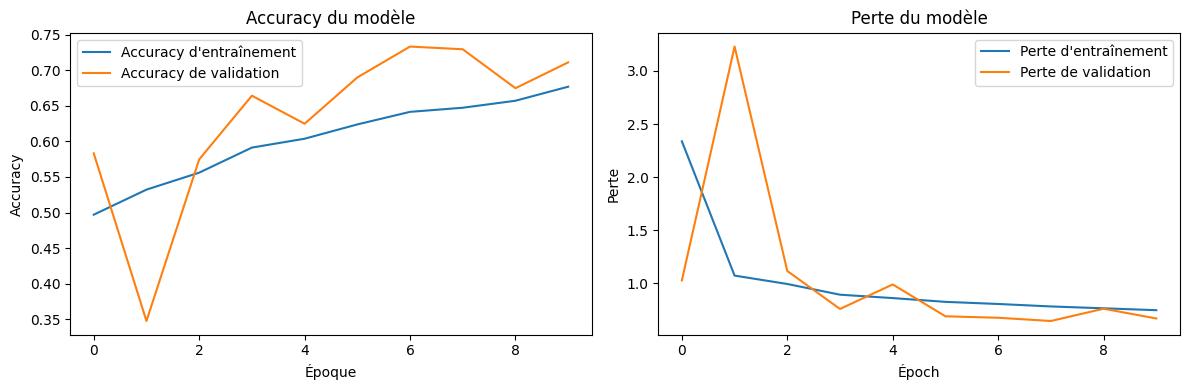

In [23]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Define the L2 regularization value
regularization_value = 0.001

# Create the seventh model with doubled filters and a dropout rate of 0.4
seventh_model = create_test_model(
    batch_size=batch_s,
    loss_function=loss_function,
    optimizer='adam',
    dropout_rate=0.4,
    regularization_value=regularization_value,
    filter_factor=2,
    use_data_augmentation=True,
    add_additional_layer=True,
    use_batch_normalization=True,
    image_height=image_h,
    image_width=image_w
)

# Train the seventh model with the existing callbacks and ReduceLROnPlateau
epochs = 10

history_seventh_model = seventh_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=get_callbacks() + [reduce_lr]
)

# Visualize the performance of the seventh model
plot_training_history(history_seventh_model, "7_filter_augmentation_model.png")


#### 3.3.8. ****Modèle Final : Une Simplicité Retrouvée****

Le modèle final a finalement abandonné la ****régularisation L2**** et est revenu à un ****Dropout plus modéré de 0.2****, tout en conservant une architecture plus complexe avec des filtres plus nombreux (32, 64, 128) et un ****Dense Layer de 256 unités**** avant la sortie. Ce modèle présente les caractéristiques suivantes :

- ***Trois couches convolutionnelles*** accompagnées de MaxPooling pour extraire des caractéristiques tout en réduisant la dimensionnalité.
- ***Batch Normalization maintenu***, malgré les fluctuations initiales, pour accélérer l’apprentissage tout en minimisant les gradients instables.
- ***Dropout à 0.2***, suffisant pour régulariser le modèle sans sacrifier sa capacité à bien apprendre.

Ce modèle final a montré une ****accuracy de validation stable à 88.8%****, tout en conservant une convergence régulière, sans les oscillations observées dans les versions intermédiaires.

Le schéma ci-dessous illustre l'architecture finale de notre modèle :

In [24]:
batch_size = 24
image_height = 224
image_width = 224

train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

def create_model(input_shape=(image_h, image_w, 3)):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))

    model.add(data_augmentation)

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))


    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(class_num, activation='softmax'))

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer="adam", loss=loss_function, metrics=['accuracy'])

    model.summary()

    return model

model = create_model()

Found 32755 files belonging to 5 classes.
Using 26204 files for training.
Using 6551 files for validation.


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,954,501 (60.86 MB)

 Trainable params: 15,954,501 (60.86 MB)

 Non-trainable params: 0 (0.00 B)

#### ****Conclusion****

Le processus d'évolution du modèle, du modèle initial à la version finale, a été guidé par une série d’optimisations itératives visant à stabiliser l'apprentissage tout en maximisant la généralisation. Les étapes d'ajout de ****Batch Normalization**** et de ****régularisation L2**** ont introduit des fluctuations qui ont nécessité l'intervention de techniques plus avancées, comme ****ReduceLROnPlateau****. En fin de compte, le modèle final a trouvé un équilibre optimal sans régularisation explicite mais avec un Dropout modéré et une architecture plus complexe, conduisant à des performances stables et robustes sur le set de validation.

### **3.4. Entraînement du modèle**

Maintenant que le modèle est défini et compilé, nous pouvons procéder à l'entraînement. Dans cette étape, nous entraînons le modèle en utilisant le dataset d'entraînement tout en évaluant ses performances sur le dataset de validation à chaque époque. Nous utilisons également les callbacks définis précédemment pour sauvegarder les meilleurs poids, suivre l'entraînement avec TensorBoard, et arrêter l'entraînement de manière anticipée si nécessaire.

Les paramètres d'entraînement :

- **Nombre d'epochs** : Le modèle est entraîné pendant 10 epoch, mais cela peut être ajusté en fonction des besoins du projet et des performances observées.
- **Callbacks** : Les callbacks définis précédemment (sauvegarde des poids, TensorBoard, et EarlyStopping) sont activés pendant l'entraînement pour surveiller et optimiser le processus.
- **Sauvegarde du modèle** : Une fois l'entraînement terminé, le modèle complet est sauvegardé sous forme de fichier `.keras`.



In [25]:
def run_model(model, epochs, load_path=None):
    if load_path is not None:
        model.load_weights(load_path)
        return False
    else:
        history = model.fit(
            train_set,
            epochs=epochs, 
            validation_data=test_set,
            callbacks=get_callbacks()
        )
        model.save(f"{paths['model_path']}/model.keras")
        return history

history = run_model(
    model,
    epochs=50
)

Epoch 1/10


Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2024-10-09 22:44:15.314438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 513 of 1000
2024-10-09 22:44:17.173167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-09 22:44:21.204937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5509 - loss: 1.1554
Epoch 1: val_loss improved from inf to 0.58040, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-01-0.58.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 236s 267ms/step - accuracy: 0.5510 - loss: 1.1550 - val_accuracy: 0.7545 - val_loss: 0.5804
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7601 - loss: 0.5781
Epoch 2: val_loss improved from 0.58040 to 0.47060, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-02-0.47.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 218s 266ms/step - accuracy: 0.7601 - loss: 0.5780 - val_accuracy: 0.8086 - val_loss: 0.4706
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8047 - loss: 0.4921
Epoch 3: val_loss improved from 0.47060 to 0.42393, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_1/weights/model_early/weights-epoch-03-0.42.weights.h5
819/819 

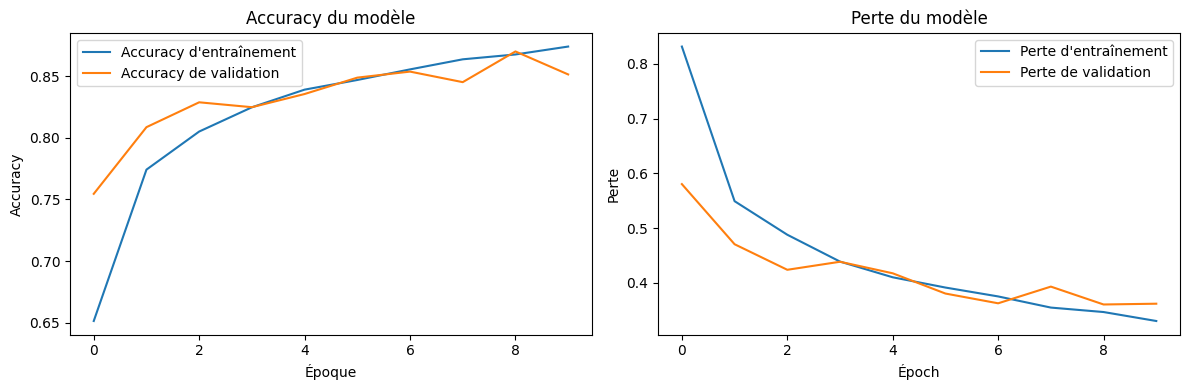

In [26]:
plot_training_history(history, "8_final_model.png")

Les résultats montrent une amélioration continue de la précision sur les données d'entraînement au fil des epoch, ce qui indique que le modèle apprend bien les caractéristiques des données. Cependant, la précision de validation commence à stagner après l’époque 5, suggérant un début de sur-apprentissage. L’utilisation de techniques de régularisation supplémentaires, comme l’ajout de dropout ou l’augmentation des données, pourrait permettre d’atténuer ce phénomène.

### **3.5. Tri des images en fonction des prédictions**

Cette section décrit une procédure automatisée de tri des images, basée sur les prédictions du modèle entraîné.

1. **Prétraitement des images** : La fonction `preprocess_image` ajuste la taille des images (224x224 pixels) et les convertit en un format exploitable par le modèle pour la prédiction.
   
2. **Prédiction de la classe "photo"** : La fonction `is_photo` fait appel au modèle pour prédire si une image appartient à la classe "photo". Elle retourne un booléen indiquant si c'est le cas.

3. **Tri des images** : La fonction `sort_images` parcourt un dossier d'images non triées, détermine pour chaque image si elle est une "photo", et la copie dans un dossier dédié si la prédiction est positive.

Cette méthode permet de trier efficacement les images selon leur classe prédite par le modèle, assurant un classement automatique sans intervention manuelle.

In [27]:
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_h, image_w))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def is_photo(model, img_path):
    img = preprocess_image(img_path)
    prediction = model.predict(img)
    class_name = class_names[np.argmax(prediction)]
    return class_name == "photo"

def sort_images(model):
    number_photos = 0
    for img_file in os.listdir(paths['unsorted_validation_data_path']):
        img_path = os.path.join(paths['unsorted_validation_data_path'], img_file)

        if os.path.isfile(img_path):
            if is_photo(model, img_path):
                number_photos += 1
                shutil.copy2(img_path, f"{paths['sorted_validation_data_path']}/{img_file}")
                print(f"Image {img_file} detected as a photo. Copied to the photo folder.")
            else:
                print(f"Image {img_file} not detected as a photo.")
    print(f"Total number of photos detected: {number_photos}")

                
sort_images(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Image text_00226.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image Mp-041-1-sz1.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image painting_01821.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image painting_02125.jpg detected as a photo. Copied to the photo folder.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image painting_09307.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image schematics_02989.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image schematics_03459.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image painting_08580.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Image text_00225.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image 968.png not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image text_00635.jpg not detected as a photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

### Conclusion du projet de classification d'images

Ce projet de classification d'images nous a permis d'explorer l'ensemble du processus de traitement des données et de création d'un modèle performant, de la préparation des données à l'entraînement et à l'évaluation. Nous avons commencé par préparer des données de manière rigoureuse, en utilisant différentes bibliothèques pour gérer les fichiers, créer des visualisations, et garantir la qualité des données. Cela a posé des bases solides pour la création d'un modèle de réseau de neurones efficace.

Lors de la construction du modèle, nous avons conçu une architecture composée de plusieurs couches de convolution et de pooling, avec l'ajout de techniques de régularisation comme le dropout pour limiter le surapprentissage. Le modèle a été entraîné sur plusieurs epochs, et les résultats ont montré une amélioration continue de la précision sur les données d'entraînement, bien que la précision de validation ait commencé à stagner, suggérant un début de sur-apprentissage. Cela met en évidence l'importance d'utiliser des techniques de régularisation plus avancées, telles que l'augmentation de données, pour améliorer la généralisation.

Ce projet illustre les défis inhérents à la construction de modèles de classification d'images, notamment en ce qui concerne l'équilibre entre l'apprentissage et la généralisation. Nous avons obtenu des résultats prometteurs, mais il reste des pistes d'amélioration, telles que l'optimisation des hyperparamètres et l'utilisation de modèles préentraînés plus avancés, pour continuer à améliorer la performance du modèle. Nous espérons que ces résultats serviront de base pour des travaux futurs, avec des possibilités d'application dans des contextes réels et diversifiés.

### Conclusion du projet de classification d'images

Ce projet de classification d'images nous a permis d'explorer l'ensemble du processus de traitement des données et de création d'un modèle performant. Cela inclut la préparation des données, l'entraînement et l'évaluation du modèle. Nous avons commencé par préparer des données de manière rigoureuse, en utilisant différentes bibliothèques pour gérer les fichiers, créer des visualisations, et garantir la qualité des données. Ces étapes ont posé des bases solides pour la création d'un modèle de réseau de neurones efficace, en garantissant la qualité et la pertinence des données utilisées.

Lors de la construction du modèle, nous avons conçu une architecture composée de plusieurs couches de convolution et de pooling, avec l'ajout de techniques de régularisation comme le dropout, qui est efficace pour réduire le surapprentissage en désactivant aléatoirement certaines unités du réseau lors de l'entraînement. Le modèle a été entraîné sur plusieurs epochs, et les résultats ont montré une amélioration continue de la précision sur les données d'entraînement, bien que la précision de validation ait commencé à stagner, suggérant un début de sur-apprentissage. Cela met en évidence l'importance d'utiliser des techniques de régularisation plus avancées, telles que l'augmentation de données (par exemple, des transformations aléatoires des images), pour améliorer la généralisation.

Ce projet illustre les défis inhérents à la construction de modèles de classification d'images, notamment en ce qui concerne l'équilibre entre l'apprentissage et la généralisation. Nous avons obtenu des résultats prometteurs, mais il reste des pistes d'amélioration, telles que l'optimisation des hyperparamètres pour affiner les performances du modèle, et l'utilisation de modèles préentraînés plus avancés pour bénéficier des avancées récentes en vision par ordinateur. Nous espérons que ces résultats serviront de base pour des travaux futurs, avec des possibilités d'application dans des contextes réels et diversifiés.